In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np


# Učitajte podatke o aerodromima i rutama
airports = pd.read_csv('airports.dat', header=None, names=['AirportID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz', 'Type', 'Source'])
routes = pd.read_csv('routes.dat', header=None, names=['Airline', 'AirlineID', 'SourceAirport', 'SourceAirportID', 'DestinationAirport', 'DestinationAirportID', 'Codeshare', 'Stops', 'Equipment'])

# Креирање графа
G = nx.Graph()

# Додавање чворова за сваки аердором
for _, airport in airports.iterrows():
    G.add_node(airport['IATA'], Name=airport['Name'], City=airport['City'], Country=airport['Country'], Latitude=airport['Latitude'], Longitude=airport['Longitude'])

# Додавање грана на основу рута
for _, route in routes.iterrows():
    source_airport_data = airports[airports['IATA'] == route['SourceAirport']]
    dest_airport_data = airports[airports['IATA'] == route['DestinationAirport']]
    
    # Провера да ли постоји аеродром
    if not source_airport_data.empty and not dest_airport_data.empty:
        source_airport = source_airport_data['IATA'].values[0]
        dest_airport = dest_airport_data['IATA'].values[0]
        G.add_edge(source_airport, dest_airport)

# Креирање матрице повезаности
adjacency_matrix = nx.to_numpy_array(G)



In [2]:
adjacency_matrix

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(adjacency_matrix, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.7026653443266014


In [9]:
# Стандардизација података
scaler = StandardScaler()
adjacency_matrix_scaled = scaler.fit_transform(adjacency_matrix)

# DBSCAN 
dbscan = DBSCAN(eps=1.2, min_samples=10, metric='euclidean')
cluster_labels = dbscan.fit_predict(adjacency_matrix_scaled)




In [6]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(adjacency_matrix_scaled, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.24406847193799172


min_samples=10, broj klastera=13
min_samples=8, broj klastera=21
min_samples=6, broj klastera=35


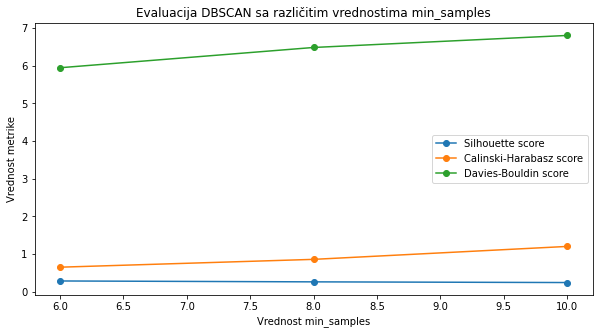

In [24]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


min_samples_values = range(10, 4, -2) 

silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []


for min_samples in min_samples_values:
    # Kreiranje DBSCAN modela sa trenutnom vrednosti min_samples
    dbscan = DBSCAN(eps=1.2, min_samples=min_samples, metric='euclidean')
    cluster_labels = dbscan.fit_predict(adjacency_matrix_scaled)
    
   
    if len(set(cluster_labels)) > 1:
        silhouette_scores.append(silhouette_score(adjacency_matrix_scaled, cluster_labels))
        calinski_harabasz_scores.append(calinski_harabasz_score(adjacency_matrix_scaled, cluster_labels))
        davies_bouldin_scores.append(davies_bouldin_score(adjacency_matrix_scaled, cluster_labels))
    else:
        silhouette_scores.append(0)  #
        
    # Ispis rezultata za trenutnu vrednost min_samples
    print(f"min_samples={min_samples}, broj klastera={len(set(cluster_labels))}")

# Vizualizacija rezultata
plt.figure(figsize=(10, 5))
plt.plot(min_samples_values, silhouette_scores, marker='o', label='Silhouette score')
plt.plot(min_samples_values, calinski_harabasz_scores, marker='o', label='Calinski-Harabasz score')
plt.plot(min_samples_values, davies_bouldin_scores, marker='o', label='Davies-Bouldin score')
plt.xlabel('Vrednost min_samples')
plt.ylabel('Vrednost metrike')
plt.title('Evaluacija DBSCAN sa različitim vrednostima min_samples')
plt.legend()
plt.show()


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

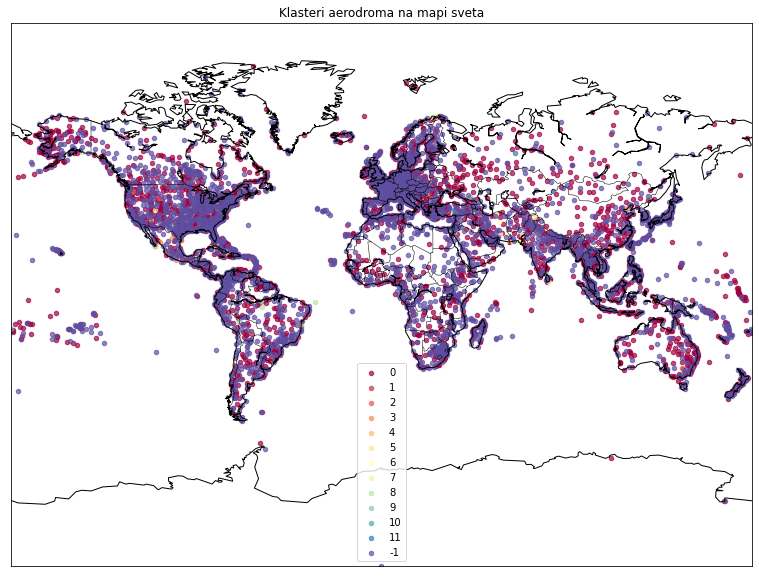

In [10]:
# Визуелизација на мапи света
plt.figure(figsize=(16, 10)) 
m = Basemap(projection='mill', resolution='c', lon_0=0)
m.drawcoastlines()
m.drawcountries()


x, y = m(list(airports['Longitude']), list(airports['Latitude']))


unique_labels = set(cluster_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for label, color in zip(unique_labels, colors):
    cluster_mask = cluster_labels == label
    cluster_x = [x[i] for i, mask in enumerate(cluster_mask) if mask]
    cluster_y = [y[i] for i, mask in enumerate(cluster_mask) if mask]
    m.scatter(cluster_x, cluster_y, s=20, c=color, label=label, alpha=0.7)

plt.legend()
plt.title('Klasteri aerodroma na mapi sveta')
plt.show()
